### Vision Transformer model - Evaluation

source code (with some changes): https://drive.google.com/file/d/1ZU1u3NnPduGHmIwiu8nSBoj5gYRPSjEq/view?source=post_page-----13fc4ce253d7--------------------------------

Original Article: https://dohyeongkim.medium.com/image-to-latex-using-vision-transformer-13fc4ce253d7

In [1]:
!pip install tensorflow==2.13.1 --force-reinstall
!pip install numpy==1.24.3 --force-reinstall
!pip install einops

import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm
import numpy as np

import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 1

In [2]:
image_size = 160
data_root = "/kaggle/input/latex-data/latex_data"

class LatexDataset:
    def __init__(self, set='train', batch_size=32):
        self.data_root = data_root
        self.set = 'train'
        self.batch_size = batch_size
        self.train_dict = np.load(os.path.join(self.data_root, set + '_buckets.npy'), allow_pickle=True).tolist()
        self.data_length = np.sum([len(self.train_dict[x]) for x in self.train_dict.keys()])
        print("Length of %s data: " % set, self.data_length)
    
    def __len__(self):
        return self.data_length
    
    def __iter__(self):
        for keys in self.train_dict.keys():
            train_list = self.train_dict[keys]
            N_FILES = (len(train_list) // self.batch_size) * self.batch_size
            for batch_idx in range(0, N_FILES, self.batch_size):
                train_sublist = train_list[batch_idx:batch_idx + self.batch_size]
                imgs = []
                input_tokens = []
                label_tokens = []
                for x, y in train_sublist:
                    img = Image.open(os.path.join(self.data_root, 'images_processed/') + x)
                    img = img.resize((image_size, image_size))
    
                    img = np.asarray(img)[:,:,0][:,:,None] / 255.0
                    
                    imgs.append(img)
                    input_tokens.append(y[:-1])
                    label_tokens.append(y[1:])

                imgs = np.asarray(imgs, dtype=np.float32).transpose(0,1,2,3)
                lens = [len(x) for x in input_tokens]

                Y_input_tokens = np.zeros((self.batch_size, max(lens)), dtype=np.int32)
                for i, input_token in enumerate(input_tokens):
                    Y_input_tokens[i, :len(input_token)] = input_token

                Y_label_tokens = np.zeros((self.batch_size, max(lens)), dtype=np.int32)
                for i, label_token in enumerate(label_tokens):
                    Y_label_tokens[i, :len(label_token)] = label_token

                yield imgs, Y_input_tokens, Y_label_tokens
    
    __call__ = __iter__

In [3]:
test_ds_gen = LatexDataset(set='test', batch_size=8) 
test_ds = tf.data.Dataset.from_generator(test_ds_gen, (tf.float32, tf.int32, tf.int32))

Length of test data:  10355


imgs.shape:  (8, 160, 160, 1)
Y_input_tokens.shape:  (8, 109)
Y_label_tokens.shape:  (8, 109)
Y_input_token:  tf.Tensor(
[500 486   4 492   8 492 461 495 332 497   5  35 394 495   4 493   9 493
 461 495 332 497   5 461 495  21 497   7   4 492   9 492 461 495 332 497
   5 461 495  21 497   9   4 496 487   9 487 461 495 332 497 496   9 473
 196   5 461 495  21 497 497  74   8   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0], shape=(109,), dtype=int32)
Y_label_token:  tf.Tensor(
[486   4 492   8 492 461 495 332 497   5  35 394 495   4 493   9 493 461
 495 332 497   5 461 495  21 497   7   4 492   9 492 461 495 332 497   5
 461 495  21 497   9   4 496 487   9 487 461 495 332 497 496   9 473 196
   5 461 495  21 497 497  74   8 501   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   

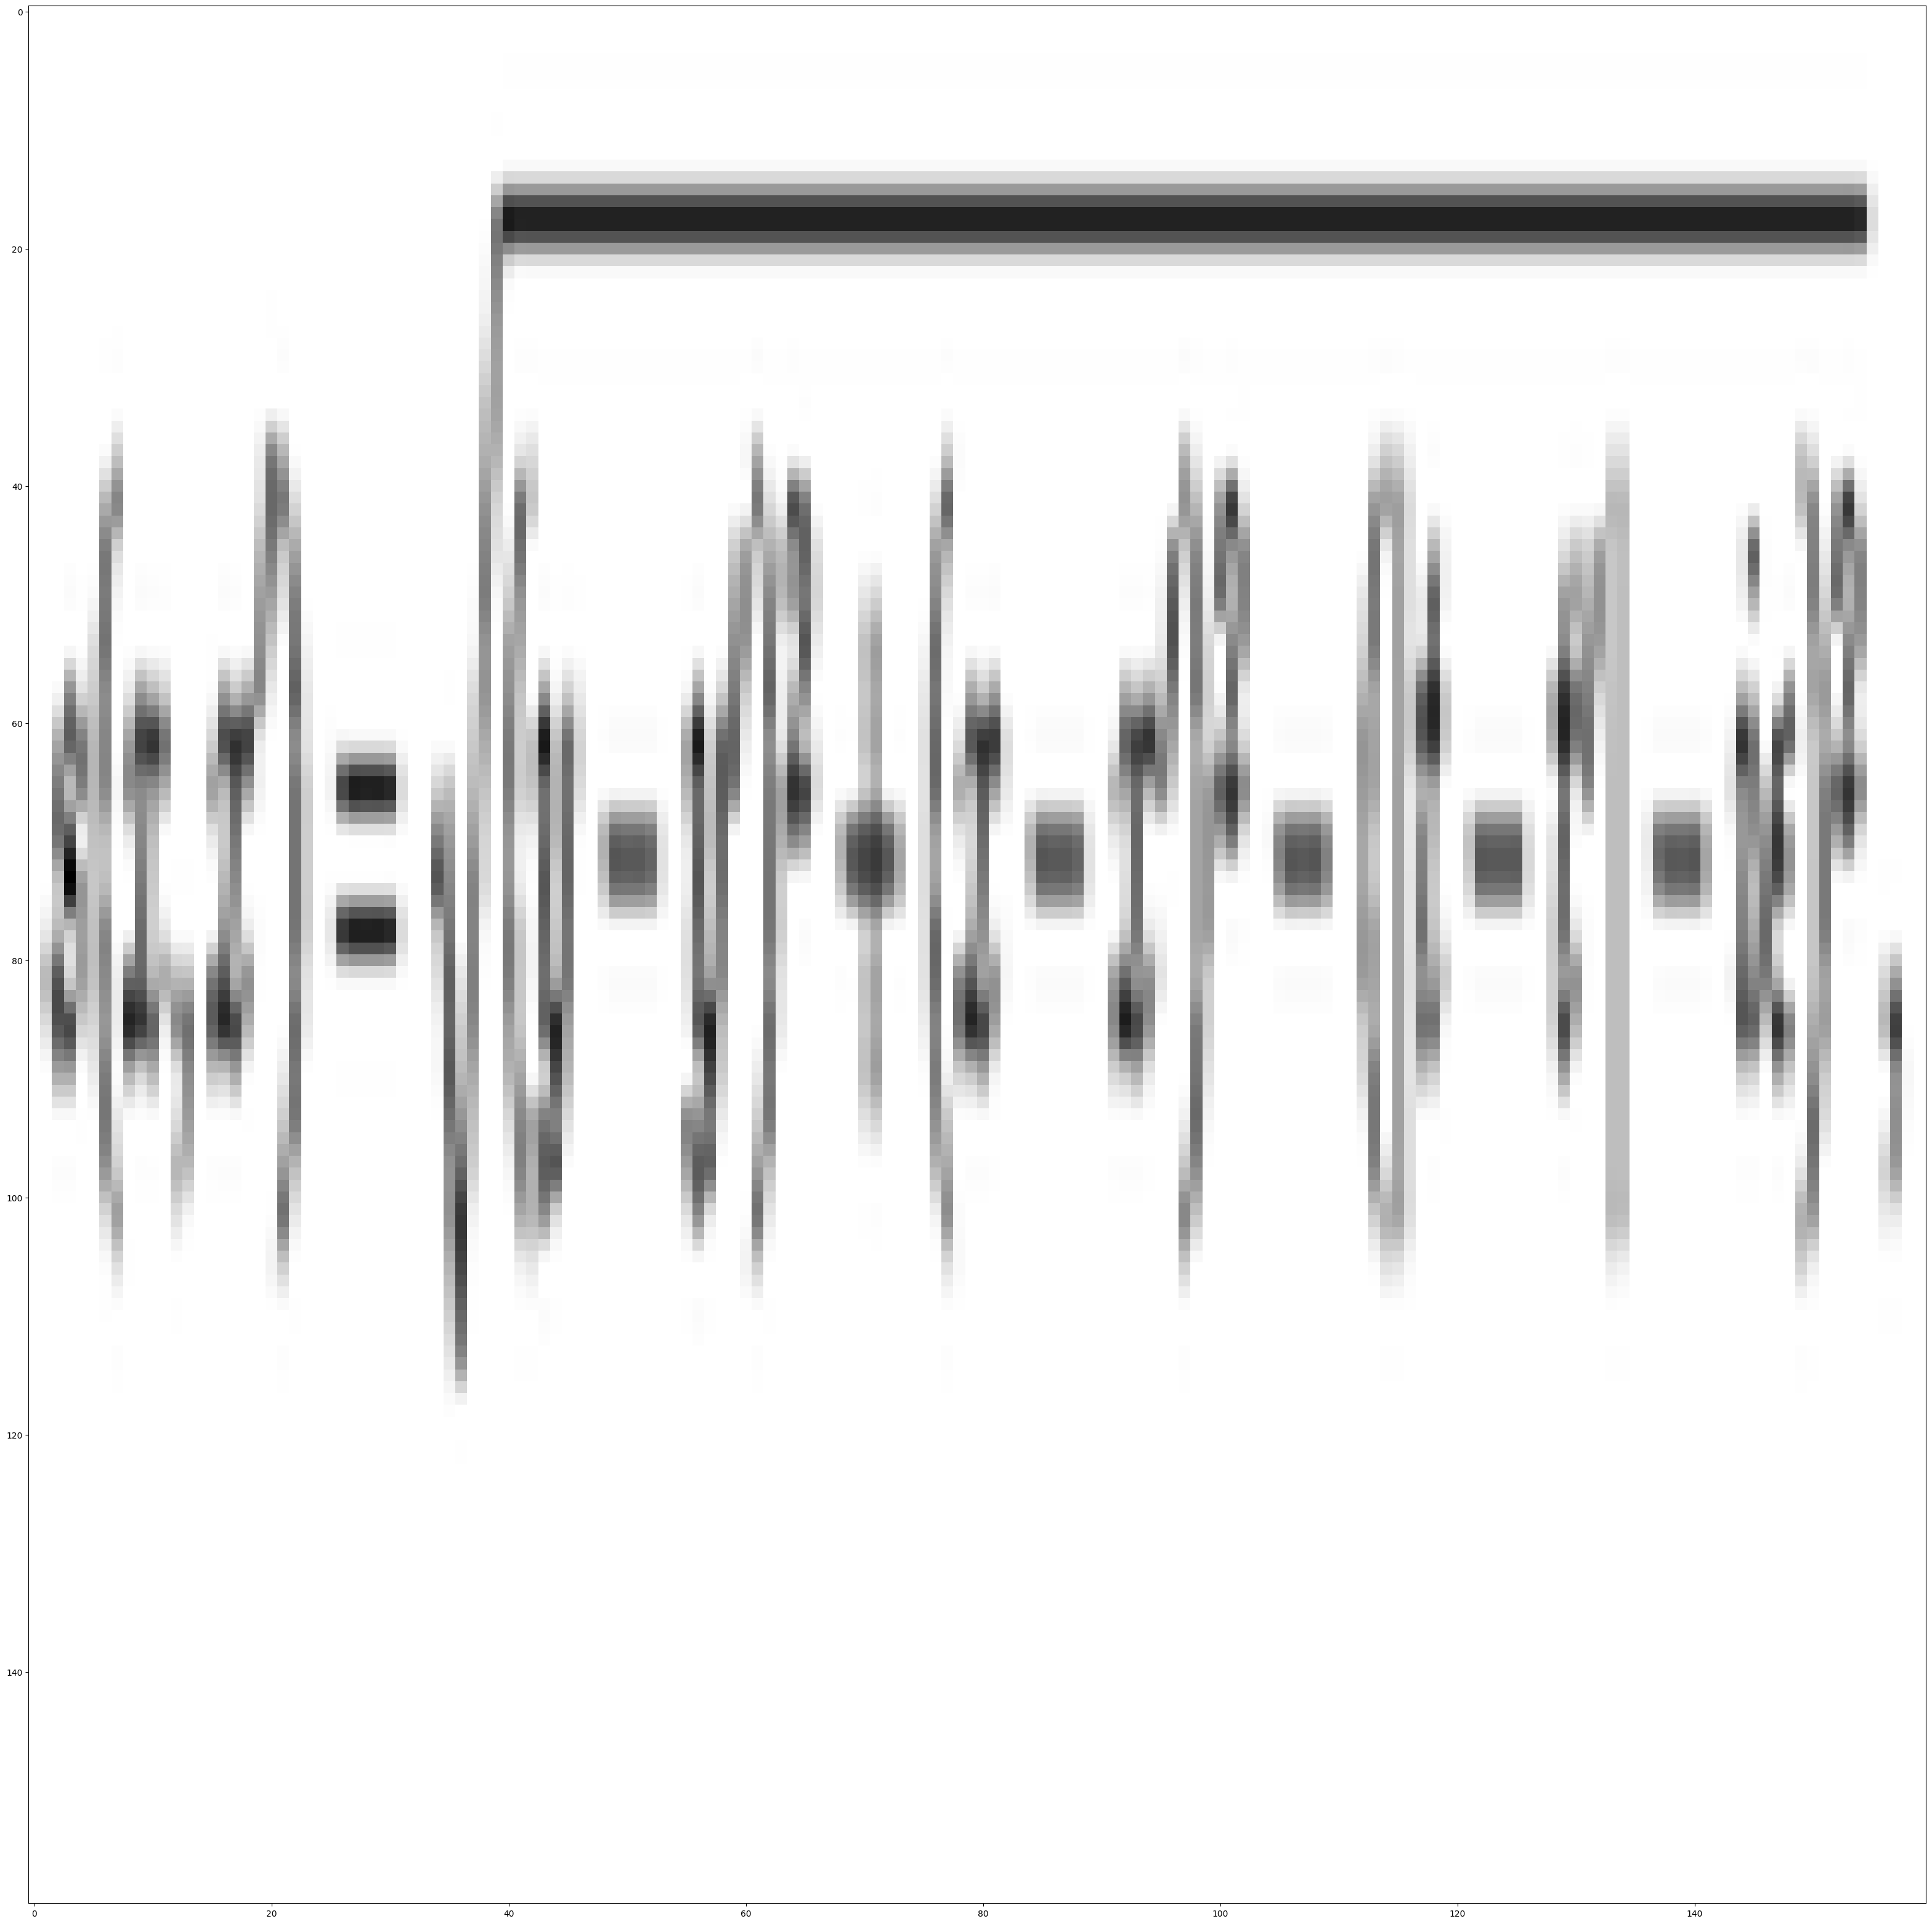

In [4]:
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from IPython.display import Image as ipythonImage
from io import StringIO
import IPython.display
import numpy as np
import cv2

displayPreds = lambda Y: display(Math(Y.split('#END')[0]))

properties = np.load(os.path.join(data_root, 'properties.npy'), allow_pickle=True).tolist()

vocab = open(os.path.join(data_root, "latex_vocab.txt")).readlines()

word_to_index = {x.split('\n')[0]:i for i, x in enumerate(vocab)}
word_to_index['#UNK'] = len(word_to_index)
word_to_index['#START'] = len(word_to_index)
word_to_index['#END'] = len(word_to_index)
index_to_word = {y:x for x, y in word_to_index.items()}

index_to_words = lambda Y: ' '.join(map(lambda x: properties['idx_to_char'][x], Y))

n = int(32)
plt.figure(figsize=(40, 40))

x = None
for idx, test_data in enumerate(test_ds):
    imgs, Y_input_tokens, Y_label_tokens = test_data
    
    print("imgs.shape: ", imgs.shape)
    print("Y_input_tokens.shape: ", Y_input_tokens.shape)
    print("Y_label_tokens.shape: ", Y_label_tokens.shape)
    
    sub_idx = -1
    
    img = imgs[sub_idx]
    Y_input_token = Y_input_tokens[sub_idx]
    Y_label_token = Y_label_tokens[sub_idx]
    print("Y_input_token: ", Y_input_token)
    print("Y_label_token: ", Y_label_token)
    
    plt.imshow(img.numpy(), cmap="gray")

    if idx == 0:
        break

In [5]:
set = 'test'
test_dict = np.load(os.path.join(data_root, set + '_buckets.npy'), allow_pickle=True).tolist()
test_dict.keys()

dict_keys([(606, 53), (612, 40), (557, 58), (611, 53), (588, 49), (644, 84), (611, 27), (607, 39), (514, 42), (553, 43), (591, 40), (528, 25), (516, 52), (642, 49), (601, 33), (511, 43), (523, 42), (545, 25), (524, 45), (455, 248), (551, 39), (556, 50), (585, 51), (532, 42), (539, 49), (559, 50), (533, 43), (520, 43), (504, 31), (506, 29), (517, 50), (554, 47), (528, 54), (572, 46), (546, 25), (480, 126), (353, 180), (550, 51), (680, 46), (593, 52), (680, 52), (360, 40), (575, 23), (502, 29), (512, 62), (619, 57), (625, 46), (539, 54), (537, 42), (679, 53), (588, 27), (515, 33), (545, 49), (545, 42), (540, 47), (546, 54), (544, 42), (443, 133), (628, 49), (640, 220), (514, 112), (549, 37), (523, 62), (331, 233), (522, 25), (551, 51), (414, 138), (645, 58), (586, 58), (593, 45), (527, 58), (614, 41), (526, 37), (514, 55), (506, 69), (517, 26), (565, 48), (160, 40), (516, 33), (546, 49), (512, 65), (597, 58), (598, 49), (546, 43), (523, 55), (509, 44), (676, 66), (280, 40), (608, 26), (5

In [6]:
ex_path = test_dict[(400, 160)][0][0]
image_dir = os.path.join(data_root, 'images_processed')
image_dir = os.path.join(image_dir, ex_path)

img = Image.open(image_dir).convert('YCbCr')
img = img.resize((image_size, image_size))
img = np.asarray(img)[:,:,0][:,:,None]

### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


Here's a function to load an image and resize it for the model:

image.shape:  (160, 160, 1)
resized_image.shape:  (1, 160, 160, 1)
Image size: 160 X 160
Patch size: 6 X 6
Patches per image: 676
Elements per patch: 36
n:  26


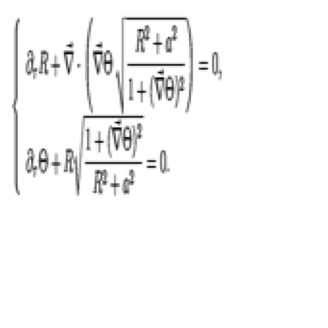

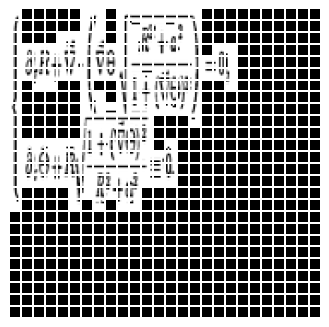

In [7]:
image_size = 160
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 512
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        
    return x


class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images, sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
        
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        return patches


class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        
        return encoded


plt.figure(figsize=(4, 4))
image = img
plt.imshow(image.astype("uint8"), cmap='gray')
plt.axis("off")

cv2.imwrite("patches/original_image.jpg", image.astype("uint8"))

print("image.shape: ", image.shape)
resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
print("resized_image.shape: ", resized_image.shape)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
print("n: ", n)

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    #print("i:", i)
    
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap='gray')
    plt.axis("off")

    #print("patch_img.numpy().astype(\"uint8\").shape: ", patch_img.numpy().astype("uint8").shape)

    cv2.imwrite("patches/patch_" + str(i) + ".jpg", patch_img.numpy().astype("uint8"))

In [8]:
def create_vit_classifier():
    inputs = tf.keras.Input(shape=(image_size, image_size, 1))
    
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    model = tf.keras.Model(inputs=inputs, outputs=representation)
    
    return model

In [9]:
vit_classifier = create_vit_classifier()

In [10]:
ex_path = test_dict[(400, 160)][0][0]
image_dir = os.path.join(data_root, 'images_processed')
image_dir = os.path.join(image_dir, ex_path)

img = Image.open(image_dir).convert('YCbCr')
img = img.resize((image_size, image_size))
img = np.asarray(img)[:,:,0][:,:,None]

print(vit_classifier(np.expand_dims(img, 0)).shape)

(1, 676, 512)


## A Transformer decoder model

In [11]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
    self.token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=depth, mask_zero=True)
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq, x])

In [12]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x, use_causal_mask=True)
    x = self.add([x, attn])
    
    return self.layernorm(x)


class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    # x.shape:  TensorShape([1, 29, 256])
    # y.shape:  TensorShape([1, 1600, 512])
    #tf.print("x.shape: ", x.shape)
    #tf.print("y.shape: ", y.shape)
    
    attn, attention_scores = self.mha(query=x, value=y, return_attention_scores=True)
    self.last_attention_scores = attention_scores
    x = self.add([x, attn])
    
    return self.layernorm(x)


class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=units, dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,key_dim=units, dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      
  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    out_seq = self.self_attention(out_seq)
    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores
    out_seq = self.ff(out_seq)

    return out_seq

In [13]:
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, vocabulary_size, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(units=vocabulary_size, **kwargs)
    self.banned_tokens = banned_tokens

  def call(self, x):
    x = self.dense(x)
    return x

In [14]:
vocabulary_size = len(word_to_index)
output_layer = TokenOutput(vocabulary_size, banned_tokens=('', '#UNK', '#START'))

In [15]:
class Captioner(tf.keras.Model):
  def __init__(self, vocabulary_size, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=200, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor

    vocab = open(os.path.join(data_root, "latex_vocab.txt")).readlines()
    self.word_to_index = {x.split('\n')[0]:i for i, x in enumerate(vocab)}
    self.word_to_index['#UNK'] = len(self.word_to_index)
    self.word_to_index['#START'] = len(self.word_to_index)
    self.word_to_index['#END'] = len(self.word_to_index)
    self.index_to_word = {y:x for x, y in self.word_to_index.items()}
    
    self.seq_embedding = SeqEmbedding(vocab_size=vocabulary_size, depth=units, max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate) for n in range(num_layers)]

    self.output_layer = output_layer

  def call(self, image, txt):
    image = self.feature_extractor(image)
      
    #image = einops.rearrange(image, 'b h w c -> b (h w) c')
    #image.shape 1:  TensorShape([1, 160, 640, 1])
    #image.shape 2:  TensorShape([1, 20, 80, 512])
    #image.shape 3:  TensorShape([1, 1600, 512])
    
    txt = self.seq_embedding(txt)
    
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

  def simple_gen(self, image, temperature=1):
    initial = self.word_to_index['#START'] # (batch, sequence)
    initial = tf.expand_dims(initial, 0)
    initial = tf.expand_dims(initial, 0) 
    
    tokens = initial # (batch, sequence) 
    
    for n in range(50):
      preds = self(image[tf.newaxis, ...], tokens).numpy()  # (batch, sequence, vocab)
      preds = preds[:,-1, :]  #(batch, vocab)
      if temperature == 0:
          next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
      else:
          next = tf.random.categorical(preds / temperature, num_samples=1)  # (batch, 1)
        
      next = tf.cast(next, tf.int32)
    
      tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

      if next[0] == self.word_to_index['#END']:
        break
    
    words = []
    for token in tokens[0, 1:-1]:
        word = index_to_word[token.numpy()]
        words.append(word)
        
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  
    return result.numpy().decode()

model = Captioner(vocabulary_size, feature_extractor=create_vit_classifier(), output_layer=output_layer, 
                  units=256, dropout_rate=0.5, num_layers=4, num_heads=8)

In [16]:
# checkpoint = tf.train.Checkpoint(model=model)
# checkpoint.restore('/kaggle/input/vit-model/tensorflow2/default/1/ViT/model_334').assert_consumed()
# model.save('/kaggle/working/model_334.keras')

In [17]:
model.load_weights('/kaggle/input/vit-model/tensorflow2/default/1/ViT/model_334')

## Evaluate

In [18]:
for ds in test_ds.shuffle(10):
    images = ds[0]
    labels = ds[1]
    
    num_image = images.shape[0]
    for i in range(1):
        labels_chars = index_to_words(labels.numpy()[i][1:]).replace('$','')
        labels_chars = labels_chars.split('#END')[0]
        print("Label: ")
        displayPreds(labels_chars)
        
        result = model.simple_gen(images[i].numpy(), temperature=0.0)

        print("Prediction: ")
        displayPreds(result)
      
    break

Label: 


<IPython.core.display.Math object>

Prediction: 


<IPython.core.display.Math object>

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

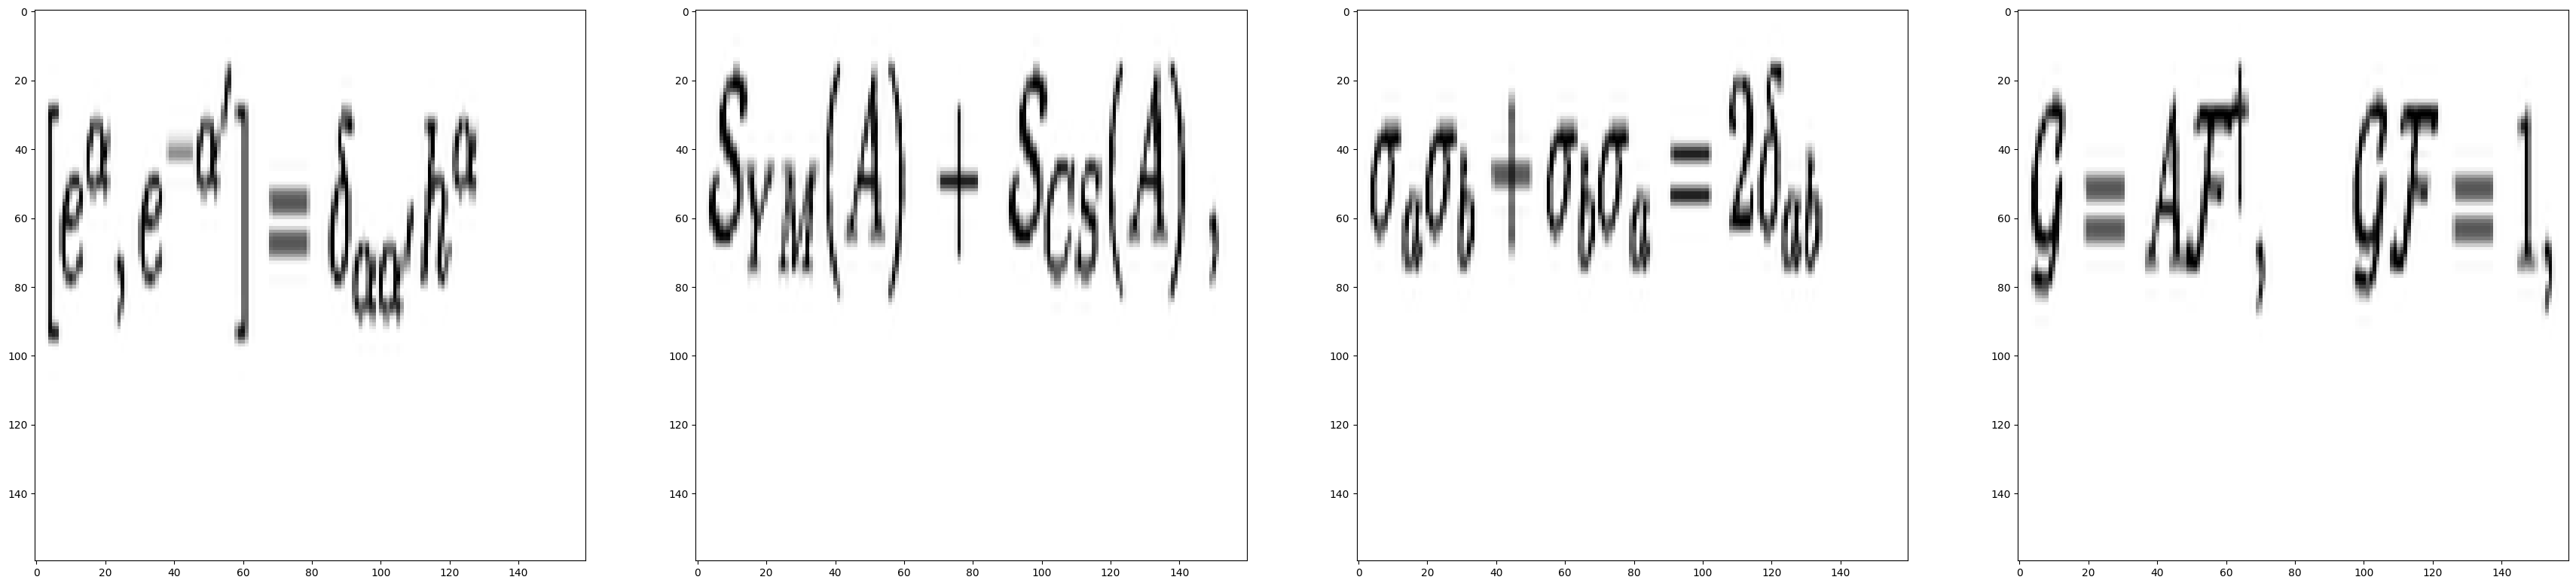

In [19]:
from IPython.display import display, Math, Latex
displayPreds = lambda Y: display(Math(Y))

step = 0

fig = plt.figure(figsize=(100, 100))

for ds in test_ds.shuffle(100):
    images = ds[0]

    num_image = images.shape[0]
    for i in range(4):
        image = images[i].numpy()
        grid_size = max(int(np.ceil(num_image / 9)), 9)
        ax = fig.add_subplot(6, grid_size, i + 1)
        img = ax.imshow(images[i].numpy(), cmap='gray')

        result = model.simple_gen(image, temperature=0.0)
        displayPreds(result)
        
    step += 1
    break

Split the output back into tokens:

In [20]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [21]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 8, 28, 676]),
 TensorShape([1, 8, 28, 676]),
 TensorShape([1, 8, 28, 676]),
 TensorShape([1, 8, 28, 676])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [22]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=26, width=26,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [23]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       0.99999994, 1.        , 1.        , 0.99999994, 1.        ,
       0.99999994, 0.99999994, 1.        , 1.        , 0.99999994,
       1.        , 0.99999994, 0.9999999 , 0.99999994, 1.        ,
       1.        , 1.        , 1.        ], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [24]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(128, 64))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/5)), 5)
      ax = fig.add_subplot(6, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i], fontsize=64))
      img = ax.imshow(image, cmap='gray')
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(), clim=[0.0, np.max(map)])

    plt.tight_layout()
    plt.savefig("attention_maps.jpg")

In [25]:
plot_attention_maps(image, str_tokens, attention_maps)

Now put that together into a more usable function:

In [26]:
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
    
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

# Add the method dynamically to the Captioner class
Captioner.run_and_show_attention = run_and_show_attention

In [27]:
# run_and_show_attention(model, image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


In [28]:
# image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
# image_path = tf.keras.utils.get_file(origin=image_url)
# image = load_image(image_path)

# run_and_show_attention(model, image)

In [29]:
from tensorflow.keras.preprocessing import image
image_shape = (160, 160)
inverse = False

def load_and_preprocess_image(img_path, target_size=image_shape, inverse=False, grayscale=False):
    """
    Load an image and make it a numpy array.
    """
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert to an array
    img_array = image.img_to_array(img)

    if grayscale:
        # Convert RGB to Grayscale
        img_array = tf.image.rgb_to_grayscale(img_array)

    # normalize to [0, 1]
    img_array = img_array / np.max(img_array)

    if inverse:
        img_array = 1 - img_array
    
    # Add a batch dimension (because the model expects a batch of images)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

In [30]:
def load_and_preprocess_images_from_dir(dir_path, target_size=image_shape, inverse=False, grayscale=False):
    X = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue
            
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse, grayscale=grayscale)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)

    X = np.array(X)
    return X

In [31]:
def load_and_preprocess_all_image_classes_from_dir(dir_path, target_size=image_shape, inverse=False, grayscale=False):
    X = []
    y = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue

        i = int(img[3:6]) - 1 # index starts at 0
        
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse, grayscale=grayscale)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)
        y.append(i)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [32]:
dir_path = "/kaggle/input/letters-and-digits/Images characters/"

dir_path_handwritten_upper = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Uppercase"
dir_path_handwritten_lower = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Lowercase"
dir_path_handwritten_math_simple = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Math - Simple"
dir_path_handwritten_math_complex = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Math - Complex"

dir_path_typed_upper = "/kaggle/input/letters-and-digits/Images characters/Typed/Uppercase"
dir_path_typed_lower = "/kaggle/input/letters-and-digits/Images characters/Typed/Lowercase"
dir_path_typed_latex_math = "/kaggle/input/letters-and-digits/Images characters/Typed/Latex Math"

img_path_zero = "/kaggle/input/letters-and-digits/Images characters/zero.png"
img_path_drawn_zero = "/kaggle/input/letters-and-digits/Images characters/drawn_zero.png"
img_path_drawn_M_close = "/kaggle/input/letters-and-digits/Images characters/M_handwritten_close.png"
img_path_drawn_M_far = "/kaggle/input/letters-and-digits/Images characters/M_handwritten_far.png"

(12, 160, 160, 1)


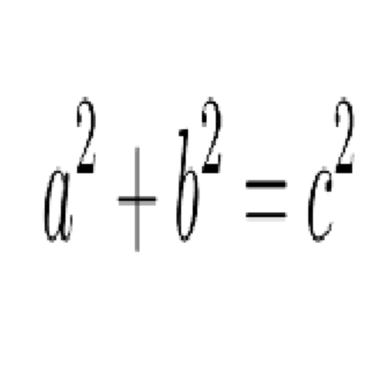

Prediction: 


<IPython.core.display.Math object>

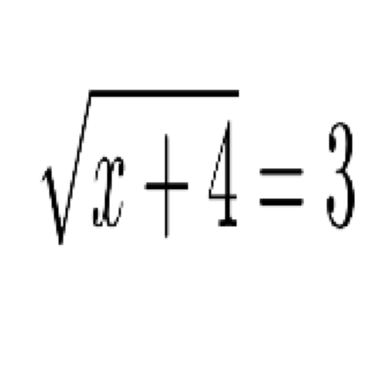

Prediction: 


<IPython.core.display.Math object>

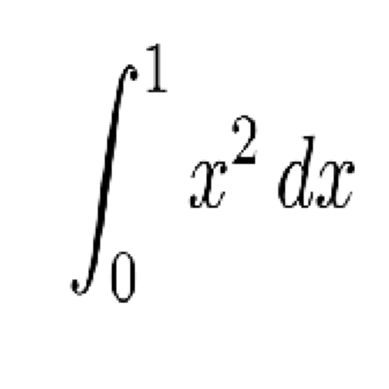

Prediction: 


<IPython.core.display.Math object>

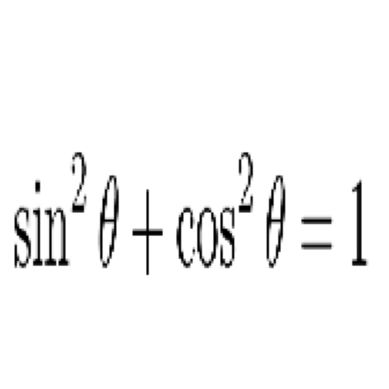

Prediction: 


<IPython.core.display.Math object>

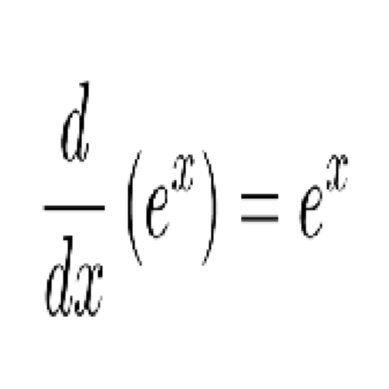

Prediction: 


<IPython.core.display.Math object>

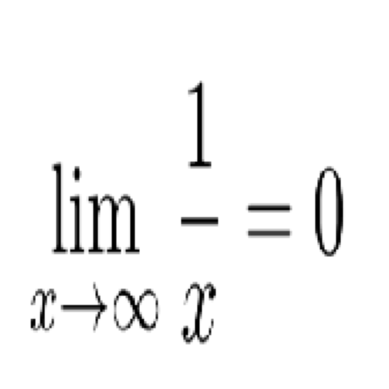

Prediction: 


<IPython.core.display.Math object>

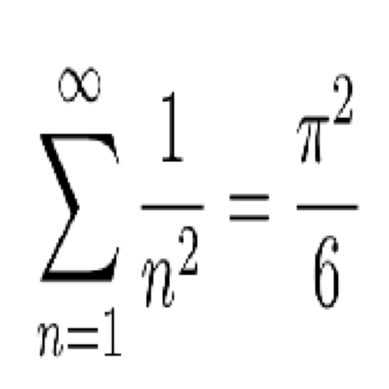

Prediction: 


<IPython.core.display.Math object>

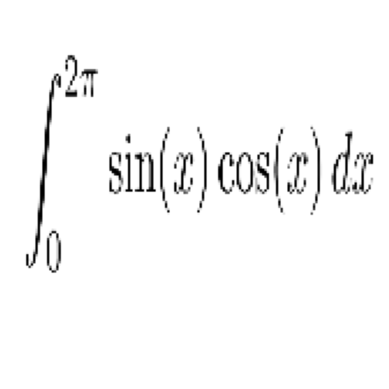

Prediction: 


<IPython.core.display.Math object>

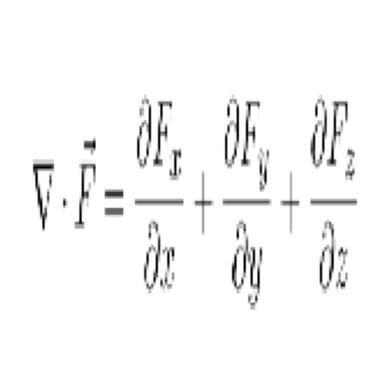

Prediction: 


<IPython.core.display.Math object>

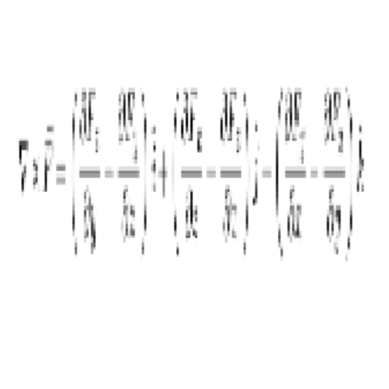

Prediction: 


<IPython.core.display.Math object>

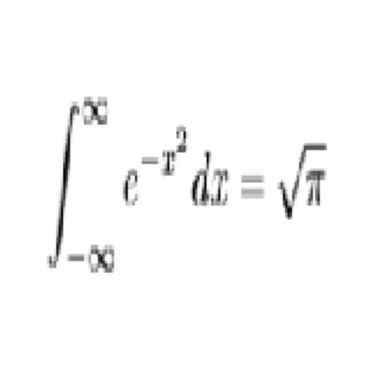

Prediction: 


<IPython.core.display.Math object>

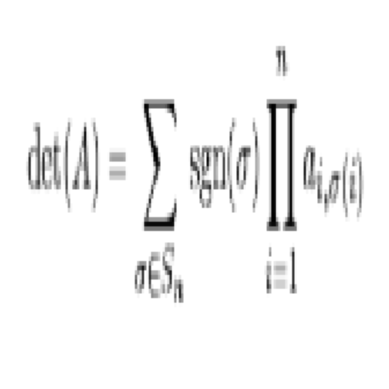

Prediction: 


<IPython.core.display.Math object>

ValueError: Models passed to `predict` can only have `training` and the first argument in `call()` as positional arguments, found: ['txt'].

In [33]:
path = dir_path_typed_latex_math 
processed_images = load_and_preprocess_images_from_dir(path, grayscale=True, inverse=inverse)
# processed_image = np.array([X_test[2]])

print(processed_images.shape)

# Make the prediction
for img in processed_images:
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    result = model.simple_gen(img, temperature=0.0)
    print("Prediction: ")
    displayPreds(result)
    
predictions = model.predict(processed_images)

# For multi-class classification (e.g., 62 classes):
# Get the index of the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

print(processed_images.shape, predicted_classes.shape)
plot_n_images(processed_images, predicted_classes, n=17, row_spacing=0.5)